In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspect Measurement table
measurement_inspector = inspect(engine)
measurement_inspector.get_table_names()

#inspect first row
measure_first_row = session.query(Measurement).first()
measure_first_row.__dict__

#columns
measure_columns = measurement_inspector.get_columns('measurement')
for c in measure_columns:
    print (c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#inspect Station table
station_inspector = inspect(engine)
station_inspector.get_table_names()

#inspect first row
station_first_row = session.query(Station).first()
station_first_row.__dict__

#columns
station_columns = station_inspector.get_columns('station')
for c in station_columns:
    print (c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
#Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
my_vacation = dt.date(2016, 6, 10) - dt.timedelta(days=12)
my_vacation

datetime.date(2016, 5, 29)

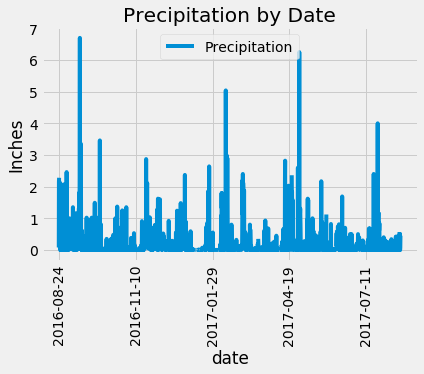

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#find the last date in the dataset - found 8/23/2017
session.query(func.max(Measurement.date)).all()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
Measurements_12m = session.query(Measurement.date, Measurement.prcp).\
  filter(Measurement.date > query_date).\
  order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(Measurements_12m, columns=['date', 'prcp'])
measurement_df.set_index('date', inplace = True)
measurement_df.rename(columns={"date":"Date", "prcp":"Precipitation"}, inplace= True)

# Sort the dataframe by date
measurement_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(rot=90)
plt.ylabel("Inches")
plt.title("Precipitation by Date")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.
station_func = func.count(Measurement.station)
session.query(Measurement.station, station_func).group_by(Measurement.station).order_by(station_func.desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
#most action Station ID = USC00519281
temp_query = [Measurement.station,
             func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)]

session.query(*temp_query).filter(Measurement.station == "USC00519281").all()



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

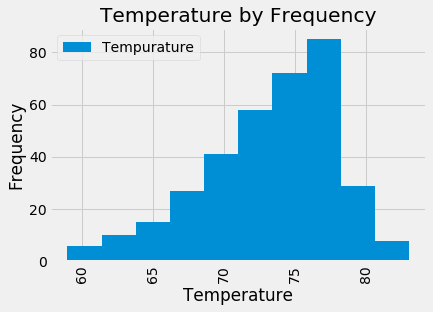

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Station_12m = session.query(Measurement.date, Measurement.tobs).\
  filter(Measurement.date > query_date).\
  filter(Measurement.station == "USC00519281").all()

# Save the query results as a Pandas DataFrame
station_df = pd.DataFrame(Station_12m, columns=['date', 'tobs'])
station_df.set_index('date', inplace = True)
station_df.rename(columns={"date":"Date", "tobs":"Tempurature"}, inplace= True)

# Sort the dataframe by date
station_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
station_df.plot.hist(rot=90)
plt.xlabel("Temperature")
plt.title("Temperature by Frequency")
plt.show()


## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-05-29','2016-06-10'))

[(64.0, 72.9, 80.0)]


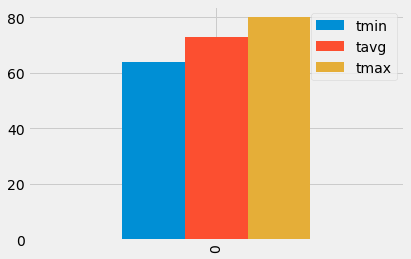

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calcs = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= '2016-05-29').filter(Measurement.date <= '2016-06-10').all()


# Save the query results as a Pandas DataFrame and set the index to the date column
calc_df = pd.DataFrame(calcs, columns=['tmin', 'tavg', 'tmax'])
#measurement_df.rename(columns={"date":"Date", "prcp":"Precipitation"}, inplace= True)

# Use Pandas Plotting with Matplotlib to plot the data
calc_df.plot.bar(rot=90)
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
